In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\zenda\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv("AEP_hourly.csv");
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [3]:
df.head(10)

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
2004-12-31 06:00:00,13038.0
2004-12-31 07:00:00,13692.0
2004-12-31 08:00:00,14297.0
2004-12-31 09:00:00,14719.0


In [4]:
df_sorted = df.sort_values(by='Datetime', ascending=True)

In [5]:
start_date = '2017-10-25'
end_date = '2018-01-31'
filtered_df = df_sorted[(df_sorted.index >= start_date) & (df_sorted.index <= end_date)]

print(filtered_df.head(60))

                      AEP_MW
Datetime                    
2017-10-25 00:00:00  12295.0
2017-10-25 01:00:00  11809.0
2017-10-25 02:00:00  11495.0
2017-10-25 03:00:00  11373.0
2017-10-25 04:00:00  11352.0
2017-10-25 05:00:00  11596.0
2017-10-25 06:00:00  12349.0
2017-10-25 07:00:00  13709.0
2017-10-25 08:00:00  14521.0
2017-10-25 09:00:00  14472.0
2017-10-25 10:00:00  14398.0
2017-10-25 11:00:00  14345.0
2017-10-25 12:00:00  14182.0
2017-10-25 13:00:00  14137.0
2017-10-25 14:00:00  14118.0
2017-10-25 15:00:00  13961.0
2017-10-25 16:00:00  13855.0
2017-10-25 17:00:00  13940.0
2017-10-25 18:00:00  14031.0
2017-10-25 19:00:00  14486.0
2017-10-25 20:00:00  14945.0
2017-10-25 21:00:00  14844.0
2017-10-25 22:00:00  14432.0
2017-10-25 23:00:00  13679.0
2017-10-26 00:00:00  12913.0
2017-10-26 01:00:00  12444.0
2017-10-26 02:00:00  12210.0
2017-10-26 03:00:00  12084.0
2017-10-26 04:00:00  12210.0
2017-10-26 05:00:00  12539.0
2017-10-26 06:00:00  13383.0
2017-10-26 07:00:00  14802.0
2017-10-26 08:

In [6]:
#AD fuller test function

def adf_test(series):
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    output = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value
    return output

# Checking stationarity of the time series
adf_result = adf_test(df_sorted['AEP_MW'])
adf_result

ADF Statistic                 -1.828588e+01
p-value                        2.302954e-30
#Lags Used                     7.100000e+01
Number of Observations Used    1.212010e+05
Critical Value (1%)           -3.430404e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64

### As the p-value is less than 0.05, The time series is stationary. We move ahead with prophet forecasting


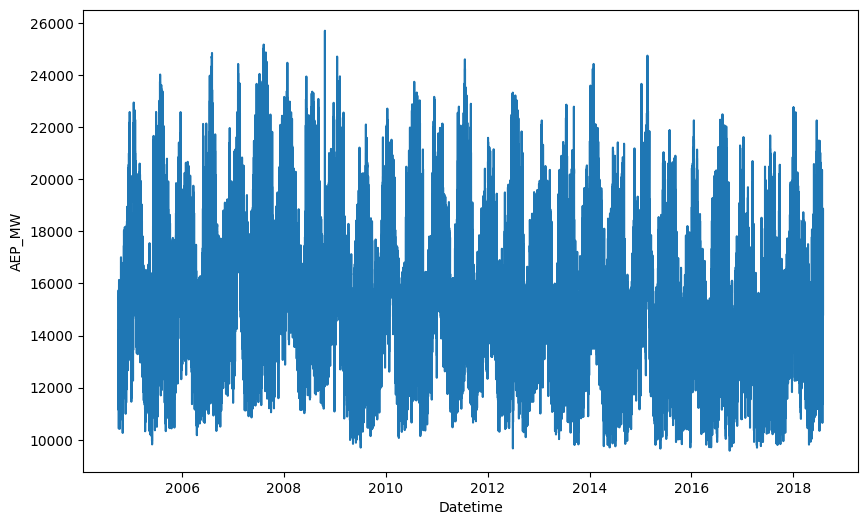

In [7]:
#Plot the dataset

plt.xlabel("Datetime")
plt.ylabel("AEP_MW")
plt.plot(df_sorted)

In [8]:
energy_data = df_sorted.reset_index().rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})

In [9]:
#Last 10% of data as validation data and rest as training data

split_point = int(len(energy_data) * 0.9)
train_data = energy_data[:split_point]
validation_data = energy_data[split_point:]

In [10]:
model = Prophet()
model.fit(train_data)

17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:00 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
future = model.make_future_dataframe(periods=len(validation_data), freq='H')
forecast = model.predict(future)

c:\Users\zenda\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


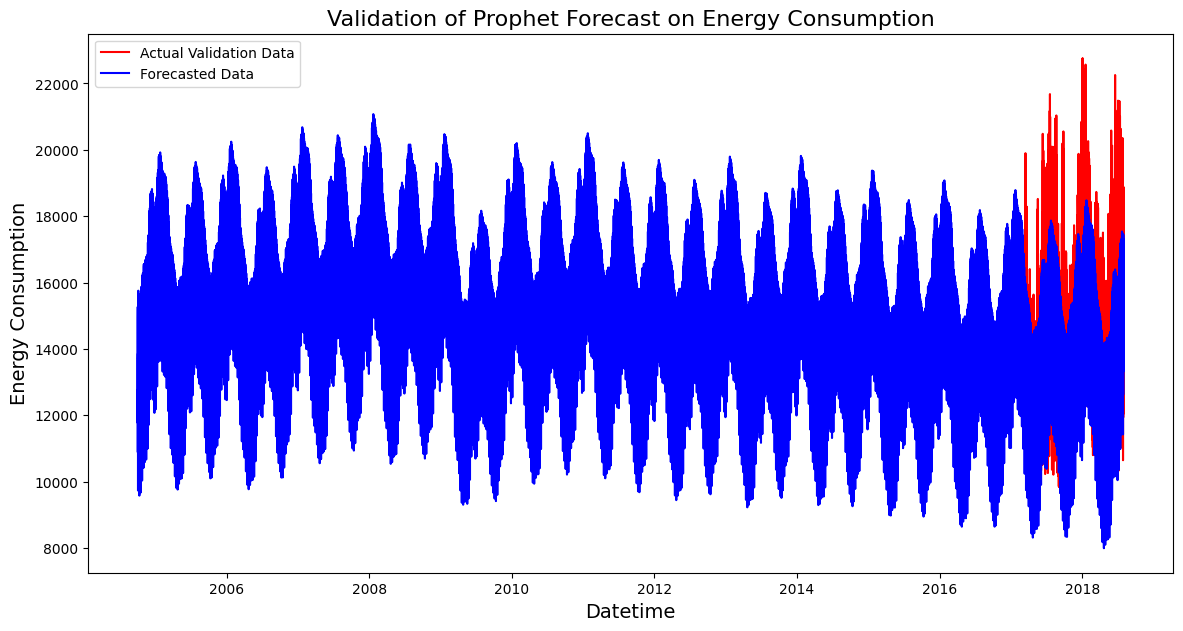

In [12]:
plt.figure(figsize=(14, 7))

# Plot actual validation data
plt.plot(validation_data['ds'], validation_data['y'], label='Actual Validation Data', color='red')

# Plot forecasted data (includes the training period + validation period)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Data', color='blue')

plt.title('Validation of Prophet Forecast on Energy Consumption', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend()
plt.show()

In [13]:
# Step 2: ARIMA Model

# Fit ARIMA model on training data (order = (p,d,q))
arima_model = ARIMA(train_data['y'], order=(5,1,0))  # You can adjust the order values based on ACF/PACF analysis
arima_model_fit = arima_model.fit()

# Forecast for validation period
arima_forecast = arima_model_fit.forecast(steps=len(validation_data))

In [14]:
# Step 3: SARIMAX Model

sarimax_model = SARIMAX(train_data['y'], order=(1,1,0), seasonal_order=(0,1,1,24))
sarimax_model_fit = sarimax_model.fit()

# Forecast for validation period
sarimax_forecast = sarimax_model_fit.forecast(steps=len(validation_data))

# Forecast in smaller chunks
# steps = 100  # Forecast in chunks of 100
# sarimax_forecast = []
# for i in range(0, len(validation_data), steps):
#     chunk_forecast = sarimax_model_fit.forecast(steps=min(steps, len(validation_data) - i))
#     sarimax_forecast.extend(chunk_forecast)

In [15]:
#MAPE Calculation function

def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

In [16]:
prophet_forecast = forecast['yhat'][-len(validation_data):].values

# Step 2: Calculate MAPE for Prophet model
validation_actual = validation_data['y'].values
prophet_mape = mape(validation_actual, prophet_forecast)

print(f"Prophet MAPE: {prophet_mape:.2f}")

Prophet MAPE: 9.11


In [17]:
validation_actual = validation_data['y'].values

arima_mape = mape(validation_actual, arima_forecast)
print(f"ARIMA MAPE: {arima_mape:.2f}")

ARIMA MAPE: 25.77


In [18]:
validation_actual = validation_data['y'].values

sarimax_mape = mape(validation_actual, sarimax_forecast)
print(f"SARIMAX MAPE: {sarimax_mape:.2f}")

SARIMAX MAPE: 809.56


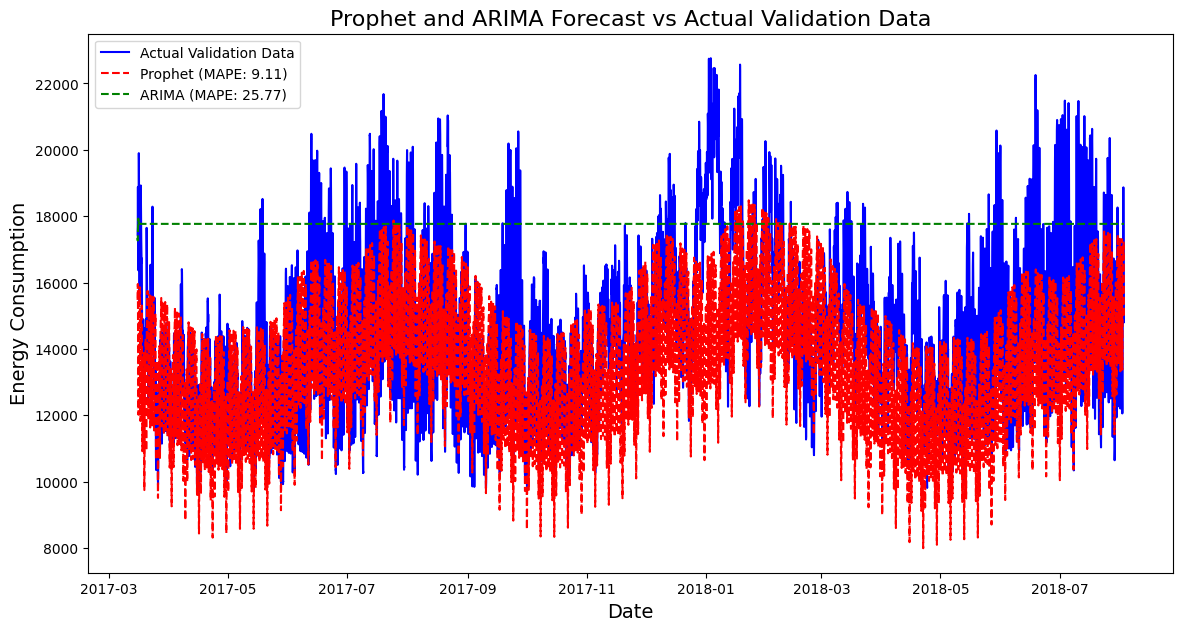

In [24]:
plt.figure(figsize=(14, 7))

# Plot the actual validation data
plt.plot(validation_data['ds'], validation_actual, label='Actual Validation Data', color='blue')

# Plot the Prophet forecast with MAPE in the label
plt.plot(validation_data['ds'], prophet_forecast, label=f'Prophet (MAPE: {prophet_mape:.2f})', color='red', linestyle='--')

# Plot ARIMA forecast
plt.plot(validation_data['ds'], arima_forecast, label=f'ARIMA (MAPE: {arima_mape:.2f})', color='green', linestyle='--')

#Plot SARIMAX Forecast
# plt.plot(validation_data['ds'], validation_actual, label=f'SARIMAX (MAPE: {sarimax_mape:.2f})', color='orange', linestyle='--')

# Titles and labels
plt.title('Prophet and ARIMA Forecast vs Actual Validation Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Energy Consumption', fontsize=14)
plt.legend(loc='best')

# Show the plot
plt.show()

17:47:32 - cmdstanpy - INFO - Chain [1] start processing
17:48:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\zenda\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


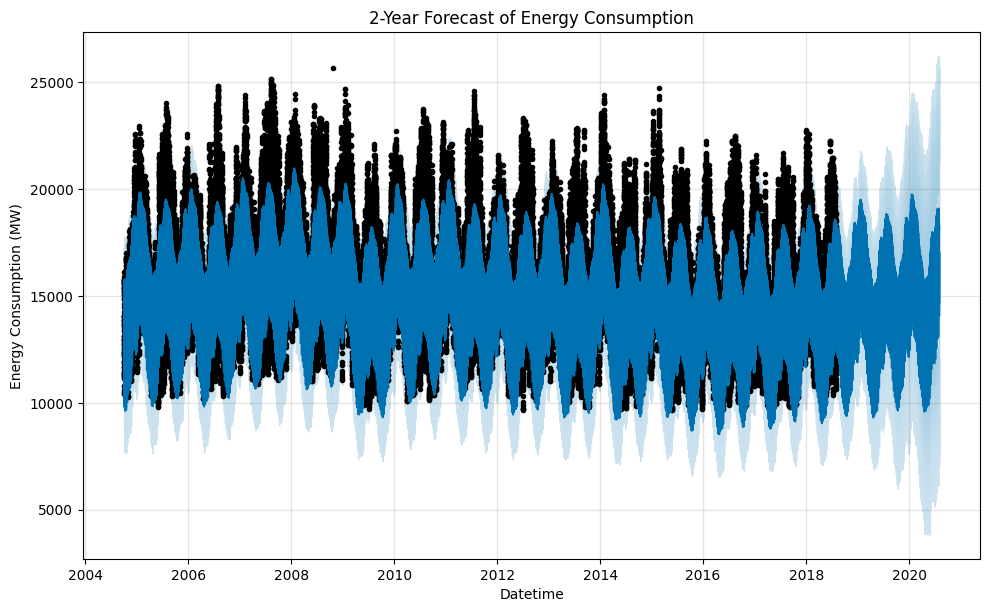

In [21]:
model_full = Prophet()
model_full.fit(energy_data)

# Forecast for the next 2 years (2 years * 365 days * 24 hours = 17520 hours)
future_full = model_full.make_future_dataframe(periods=2*365*24, freq='H')
forecast_full = model_full.predict(future_full)

# Plot the 2-year forecast
model_full.plot(forecast_full)
plt.title('2-Year Forecast of Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('Energy Consumption (MW)')
plt.show()